### Text Classification and Data Anaylsis on Cryptocurrency Related Tweets in PySpark Enviorment
---

#### Disclaimer and Background
This project is an improvement of the final project of upper year CS course "Data-Intensive Distributed Analytics" at the University of Waterloo by [Hugh Chung](https://github.com/hughyyyy) , [Joe Liang](https://github.com/JOeOJ520), and [Shawn Li](https://github.com/Shawn-Personal). The codes for setting up the Pyspark environments in this project are credited to [Ali Abedi](https://cs.uwaterloo.ca/~a2abedi/), the instructor in Winter 2022.

Data in this project is from the Kaggle post "Bitcoin Tweets" under CC0: Public Domain license. The data includes tweets that have #Bitcoin and #btc hashtags from 2016. Additional information about this dataset can be found [here](https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets).

[Cryptocurrency](https://en.wikipedia.org/wiki/Cryptocurrency) becomes a popular topic in social media and the financial market. On 30 November 2020, bitcoin hit a new all-time high of $19,860. NLP Analysis on the posts related to cryptocurrency in social media could be an interest area of study.  

The goal of this project is to demonstrate the ability to use Pyspark and big data computing in text data analysis and supervised learning: tweets text classification. And using the trained model to construct an automatic hash-tagging system for incoming tweets.

The environment and programming language used in this project mainly focus on [Pyspark](https://spark.apache.org/docs/latest/api/python/#:~:text=PySpark%20is%20an%20interface%20for,data%20in%20a%20distributed%20environment) with its RDD and Data Frame interface. Also, [Keras](https://keras.io/) in Tensorflow with [Pandas](https://pandas.pydata.org/) is used to train neural network models.


#### Pyspark Environment


Cloning from Github to obtain needed files.

In [ ]:
import shutil, os
if os.path.isdir('CryptoTweets'):
    shutil.rmtree('CryptoTweets')
! git clone https://github.com/JOeOJ520/CryptoTweets.git

To get started, let's initialize Spark.

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!tar -xzf CryptoTweets/sql-data.tgz
# install required packages
!pip install pycountry
!pip install pyecharts

To use Spark SQL and the DataFrame interface, creating a `SparkSession`.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
import random

spark = SparkSession.builder.appName("YourTest").master("local[2]").\
config('spark.ui.port', random.randrange(4000,5000)).config("spark.driver.memory", "9g").getOrCreate()

#### Data Preprocessing
The bitcoin-tweets.csv contains total 1.09G of tweets regarding bitcoins and crpytocurrecies. The below section requires a [kaggle.json](https://www.kaggle.com/docs/api) for authentication purposes in order to download the file. 

In [ ]:
from google.colab import files

uploaded = files.upload()

#Upload kaggle account verification
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

#Download dataset
!kaggle datasets download "kaushiksuresh147/bitcoin-tweets"
#unzips
!unzip bitcoin-tweets.zip

Using Pyspark SQL Interface to obtain dataframe from Bitcoin_tweets.csv and first 10 rows of the dataset are showed below.

In [5]:
#Read the csv and construct pyspark dataframe
tweets_raw = spark.read.format("csv").option("header","true").load("Bitcoin_tweets.csv")
#tweets_raw = spark.read.csv("./Bitcoin_tweets.csv")
tweets_raw.show(10)
#Create view
tweets_raw.createOrReplaceTempView("tweet")

+--------------------+--------------------+--------------------+-------------------+--------------+------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|           user_name|       user_location|    user_description|       user_created|user_followers|user_friends|    user_favourites|       user_verified|               date|                text|            hashtags|              source|         is_retweet|
+--------------------+--------------------+--------------------+-------------------+--------------+------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+
|       DeSota Wilson|         Atlanta, GA|Biz Consultant, r...|2009-04-26 20:05:09|        8534.0|        7605|               4838|               False|2021-02-10 23:59:04|Blue Ridge Bank s...|         ['bitcoin']|     Twitter W

The dimension of raw dataset is (row =  11176654, columns = 13). The sample size exceeds the need of our project goal, which might lead to extremely high computational cost. 

In [6]:
print((tweets_raw.count(), len(tweets_raw.columns)))

(11804338, 13)


Therefore, we cleans up the dataframe by removing samples with missing value and performs type conversion on multiple columns. 

In [7]:
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
#Remove all null rows
tweets = spark.sql("SELECT * FROM tweet WHERE user_name != 'null' AND user_description != 'null' \
AND user_location != 'null' AND user_created != 'null' AND user_followers != 'null' AND user_friends != 'null' \
AND user_favourites != 'null' AND user_verified != 'null' AND date != 'null' AND text != 'null'  AND hashtags != 'null' \
AND source != 'null' AND is_retweet != 'null'")
#Convert string into datetime for date col
tweets = tweets.withColumn('date', F.to_timestamp('date', 'yyyy-MM-dd'))
tweets = tweets.withColumn('user_created', F.to_timestamp('user_created', 'yyyy-MM-dd'))
#Convert string to Number/Int
tweets = tweets.withColumn("user_followers", tweets["user_followers"].cast(IntegerType()))
tweets = tweets.withColumn("user_friends", tweets["user_friends"].cast(IntegerType()))
tweets = tweets.withColumn("user_favourites", tweets["user_favourites"].cast(IntegerType()))
#Remove all null convertions that occured
tweets = tweets.filter("date is not NULL AND user_created is not NULL AND user_followers is not NULL AND user_friends is not NULL")
#Tweet left after cleaning
tweets_left = tweets.count()
#Total tweet
tweets_total = tweets_raw.count()
print("The total number of tweets is: " + str(tweets_total))
print("The total number of tweets after cleaning the data types is " + str(tweets_left))
print("Percentage of tweets removed: ", 1 - (tweets_left / tweets_total))

The total number of tweets is: 11804338
The total number of tweets after cleaning the data types is 497152
Percentage of tweets removed:  0.9578839575755964


#### Explanatory Data Analysis
##### Categorical Data
Standardlizing the "user_location" columns into countries using "pycountry" package. Using Pyspark RDDs interface to achieve parallel computing in the calculation of the frequencies of words in "hashtage", "locations", and "source", and "user_name"

In [8]:
from nltk.stem import PorterStemmer
from CryptoTweets.otherstr import *
from CryptoTweets.simple_tokenize import *

# Functions can be found in otherstr.py file in Github
# sources
sor = source(tweets).collect()
# Hashtages
hashs =hashtags(tweets).collect()
# verification
verified = user_verified(tweets).collect()
# user name
name = user_name(tweets).collect()
# Locations
loca = user_location(tweets).collect()

Here is an example of the results from the above calculations. The number indicates the frequency of each category in the dataset.

In [9]:
loca[:10]

[('others', 397175),
 ('United States', 13592),
 ('United Kingdom', 9272),
 ('Canada', 8544),
 ('India', 7791),
 ('Australia', 4415),
 ('Bangladesh', 3545),
 ('South Africa', 3314),
 ('Niger', 3206),
 ('France', 2697)]

Source (platform of original tweets)

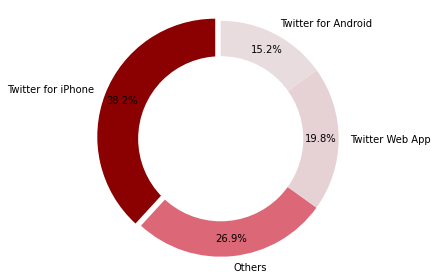

In [10]:
import matplotlib.pyplot as plt
# Plots for tweet source
x_t,y_t = zip(*sor)

fig1, ax1 = plt.subplots()
explode = (0.05,0,0,0)
colors = ['#8B0000','#db6777','#e6d1d4','#e8dcde']
ax1.pie(y_t,labels=x_t, colors = colors,  autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

plt.show()

User Location

In [13]:
# Importing required library
from pyecharts.charts import Bar
from pyecharts import options as opts


# Obtaining x and y axis from Location lists
x_hash,y_hash = zip(*loca)
bar = (
 Bar(init_opts=opts.InitOpts())
 .add_xaxis(x_hash[1:11])
 .add_yaxis("Frequency",y_hash[1:11])
 .set_global_opts(title_opts=opts.TitleOpts(title="Top 10 User Location", subtitle="standardization and removed others"))
)
bar.render_notebook()


User Verification

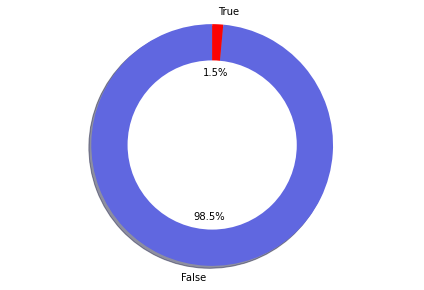

In [14]:
# Plots for verified
x_t,y_t = zip(*verified)

fig1, ax1 = plt.subplots()
explode = (0, 0)
colors = ['#6067e0','#fc0303']
ax1.pie(y_t,labels=x_t, colors = colors, explode = explode, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

plt.show()

Hashtag (Response Variable)

In [15]:
# Counting the frequency of each hashtags
x_hash,y_hash = zip(*hashs)
bar = (
 Bar(init_opts=opts.InitOpts())
 .add_xaxis(x_hash[1:11])
 .add_yaxis("Frequency",y_hash[1:11])
 .set_global_opts(title_opts=opts.TitleOpts(title="Top 10 Hashtags in the Tweets"))
)
bar.render_notebook()

We decides to use four of the most frequent hashtags and "bitcoin" as our five response variables for text classification in supervised learning. Therefore, the goal is to classify each tweet into one of the five categories using the trained model in the future sections. 

##### Numerical Variables
Performing calculation on numerical variables in the dataset, such as "Post date", "user created date", "Number of followers", and others. Obtaining the frequency of possible values in the samples.

Number of tweets in recent two years

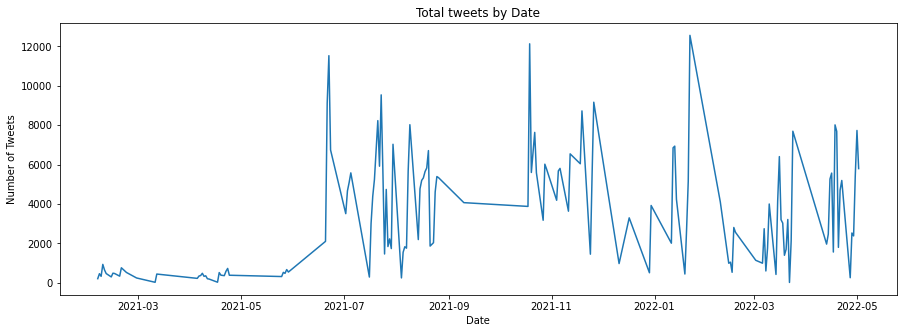

In [22]:
date_count = tweets.select("date").rdd.flatMap(lambda row: [(row[0], 1)]).\
    reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[0]).collect()
date_x, date_y = zip(*date_count)
plt.figure(figsize=(15, 5))
plt.plot(date_x, date_y)
plt.title('Total tweets by Date')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

We also performed the time series decomposition on the samples to check possible seasonal patterns and trends.




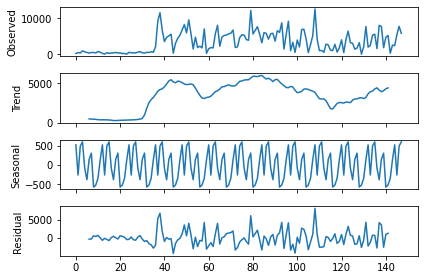

In [24]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
series = pd.DataFrame(date_count)
result = seasonal_decompose(series[1], model='additive', freq=12)
result.plot()
plt.show()

There is an increasing trend at the beginning of the plot with a very low residual. However, there is no clear pattern after 07/2021.

Account Created Date

Applying Log transformation to the number of account.

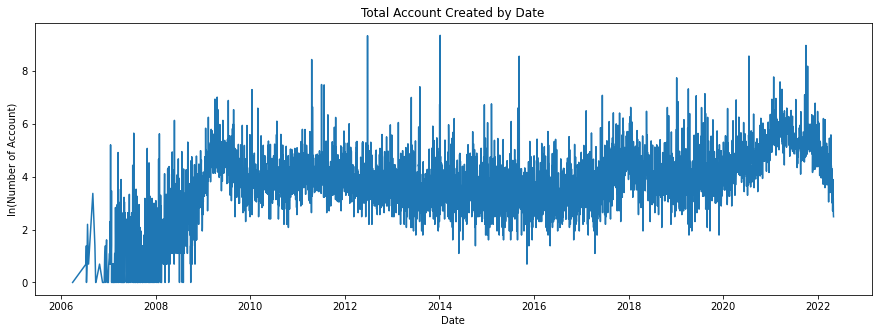

In [31]:
from numpy import log as ln
created_count = tweets.select("user_created").rdd.flatMap(lambda row: [(row[0], 1)]).\
reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[0]).collect()
#Convert list of tuple into two lists
date_x, date_y = zip(*created_count )
plt.figure(figsize=(15, 5))
plt.plot(date_x, ln(date_y))
plt.title('Total Account Created by Date')
plt.xlabel('Date')
plt.ylabel('Number of Account')
plt.show()

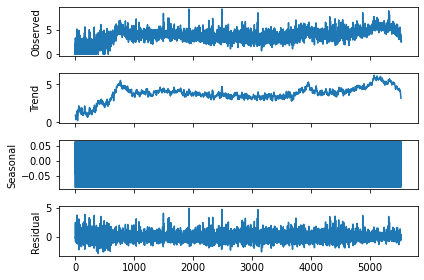

In [33]:
series = pd.DataFrame(created_count)
result = seasonal_decompose(ln(series[1]), model='additive', freq=12)
result.plot()
plt.show()

There is no significant evidence in the time series decomposition to support the existence of a seasonal pattern in the samples.

Number of followers of each tweet user

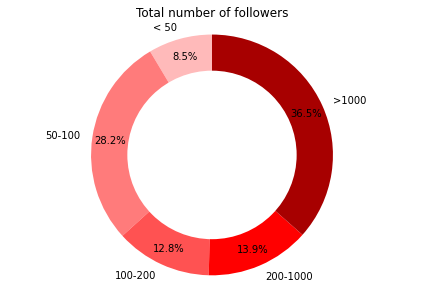

In [36]:
#Get the count of number of friends for the accounts
def checker(x):
  if x[0] < 50:
    return ('1',x[1])
  elif x[0] < 100:
    return ('2',x[1])
  elif x[0] < 200:
    return ('3',x[1])
  elif x[0] < 1000:
    return ('4',x[1])
  else:
    return ('5',x[1])
friends = tweets.select("user_friends").rdd.flatMap(lambda row: [(row[0], 1)])\
    .map(lambda x: checker(x)).reduceByKey(lambda x,y: x+y).collect()
#Convert list of tuple into two lists
friends_x, friends_y = zip(*friends)
fig1, ax1 = plt.subplots()
colors = ['#ffbaba','#ff7b7b','#ff5252','#ff0000','#a70000']
ax1.pie(friends_y,labels=['< 50','50-100','100-200','200-1000','>1000'], \
        autopct='%1.1f%%', colors = colors, startangle=90, pctdistance=0.85)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

plt.tight_layout()
plt.title('Total number of followers')
plt.show()

#### Data cleaning for text classification
After data analysis, we found that some variables can be cleaned into a more suitable format for machine learning. For example, the response variables "hashtag" can be eliminated into five categories. And the variable "sources" is a categorical variable with four levels. We converted it into indicator variables.


In [37]:
from pyspark.sql.functions import when
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import udf
from pyspark.sql.functions import year,month
from pyspark.sql import functions as F

# Cleaning response variables
tweet_ml = tweets.withColumn('hashtags', when(tweets.hashtags.contains("dog"),'Dogecoin').\
                              when(tweets.hashtags.contains("eth"),'Etherenum').\
                              when(tweets.hashtags.contains("bnb"),"binance").\
                              when(tweets.hashtags.contains("bin"),"binance").\
                              when(tweets.hashtags.contains("crypto"),'Cryptocurrency').\
                              when(tweets.hashtags.contains("btc"),'Bitcoin').\
                              otherwise('other'))

# Assigning unique_id to each row
unique_id = monotonically_increasing_id()
tweet_ml = tweet_ml.select("*").withColumn("id", unique_id)

# Cleaning locations
import pycountry
def get_country(x):
  for country in pycountry.countries:
    if country.name in x:
      return country.name
  return "others"
get_countryudf = udf(lambda z: get_country(z))

#Creating indicator variables for categorical variables data
tweet_ml = tweet_ml.na.drop().withColumn("user_location", get_countryudf("user_location"))\
.withColumn('user_verified', when(tweets.user_verified.contains("True"),1).otherwise(0))\
.withColumn("source_Iphone", when(tweets.source.contains("iPhone"),1).otherwise(0))\
.withColumn("source_Web", when(tweets.source.contains("Web"),1).otherwise(0))\
.withColumn("source_Android", when(tweets.source.contains("Android"),1).otherwise(0))\
.withColumn("post_year",year(tweet_ml.date))\
.withColumn("post_month",month(tweet_ml.date))\
.withColumn("created_year",year(tweet_ml.user_created))\
.withColumn("created_month",month(tweet_ml.user_created)).drop('is_retweet','user_name',"user_created","date","source")

tweet_ml.show(10)

+-------------+--------------------+--------------+------------+---------------+-------------+--------------------+--------------+---+-------------+----------+--------------+---------+----------+------------+-------------+
|user_location|    user_description|user_followers|user_friends|user_favourites|user_verified|                text|      hashtags| id|source_Iphone|source_Web|source_Android|post_year|post_month|created_year|created_month|
+-------------+--------------------+--------------+------------+---------------+-------------+--------------------+--------------+---+-------------+----------+--------------+---------+----------+------------+-------------+
|       others|Biz Consultant, r...|          8534|        7605|           4838|            0|Blue Ridge Bank s...|         other|  0|            0|         1|             0|     2021|         2|        2009|            4|
|       others|Biz Consultant, r...|          8534|        7605|           4838|            0|.@Tesla’s #bit

#### Nature Language Processing on user descriptions and tweets: Tokens
The user descriptions and tweets can be considered natural human language. They both share some same characteristics: long sentences, emojis, and containing some unwanted symbols.

To analyze these two variables, we first convert all texts into bags of words, including stemming, converting to lowercase, and deleting all possible stopwords.

Then we calculate the Frequency for each words and selected the highest 20 words to be included in our text classification model.


In [38]:
from simple_tokenize import simple_tokenize
from nltk.stem import PorterStemmer
import re
# Top 20 words
n = 20
#Take the text
tweets_text = tweet_ml.select("text")
#Take the user description
tweets_ud = tweet_ml.select("user_description")
# Stemming using Porter Stemmer
st = PorterStemmer()
#stop words
with open('CS431FP/CommonEnglishWord.txt') as f:
  lines = f.readlines()
  lst = list(map(lambda x: x[0:len(x)-1].lower(),lines))
  lst.append('')
  lst.append('-')
  lst.append("it's")
  lst.append("going")
  lst.append("it’s")
  lst.append("via")
  lst.append("|")
  lst.append("&")
  lst.append("/")
  lst.append('•')
  lst.append('http')
# Remove emoji since it beyonds the scope of this scope
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
# Bag of words, stemming, lowercase, stop words
rddtext = tweets_text.rdd.flatMap(lambda x: simple_tokenize(deEmojify(x[0]))).\
  map(lambda x: st.stem(x)).filter(lambda x: x not in lst).filter(lambda x: len(x) > 1).\
  map(lambda x: (x.lower(),1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1],ascending=False).cache()

Then we created variables for each of top 20 words. The value indicate the Term Frequency of each words in current text. The following table shows the resulted variables of first ten samples.

In [39]:
# Calculate the frequency and return the result as tuple
def calcfreq(t):
  wordtup = t[1]
  wordlist = []
  tweet = t[0].lower()
  for i in wordtup:
    wordlist.append(list(i))
  for i in wordlist:
    if i[0] in tweet:
      i[1] += 1
  result = [t[0]]
  for i in wordlist:
    result.append(i[1])
  return tuple(result)
  
reinit_list = rddtext.map(lambda x: (x[0], 0)).take(n)
most_frequent_tweet = rddtext.take(n)
words, freq = zip(*most_frequent_tweet)
words = list(words)
words.insert(0,'text')
reinit_rdd = tweets_text.rdd.map(lambda x:x[0]).map(lambda x: (x, reinit_list))
calc = reinit_rdd.map(lambda x: calcfreq(x))
table_tweet = calc.toDF(words)
table_tweet.show(10)

+--------------------+-------+---+---+------+---+----------+---+--------+-----+---+------+----------+--------+---+----+---+---+------+-------+----+
|                text|bitcoin| co|btc|crypto|thi|cryptocurr|eth|ethereum|price|nft|binanc|blockchain|dogecoin| ha|gift|amp| wa|invest|altcoin|doge|
+--------------------+-------+---+---+------+---+----------+---+--------+-----+---+------+----------+--------+---+----+---+---+------+-------+----+
|Blue Ridge Bank s...|      1|  1|  0|     0|  0|         0|  0|       0|    0|  0|     0|         0|       0|  1|   0|  0|  0|     0|      0|   0|
|.@Tesla’s #bitcoi...|      1|  1|  0|     1|  0|         0|  0|       0|    0|  0|     0|         0|       0|  0|   0|  0|  0|     1|      0|   0|
|Annnd #btc #Bitco...|      1|  1|  1|     0|  0|         0|  0|       0|    0|  0|     0|         0|       0|  1|   0|  0|  0|     0|      0|   0|
|Buy #Bitcoin with...|      1|  1|  0|     1|  0|         1|  0|       0|    0|  0|     0|         0|       0|  

The follow plot shows the frequency distribution of top 20 words

In [40]:
x_t,y_t = zip(*most_frequent_tweet)
bar = (
 Bar(init_opts=opts.InitOpts())
 .add_xaxis(x_t)
 .add_yaxis("Frequency",y_t)
 .set_global_opts(title_opts=opts.TitleOpts(title="Top 20 words in the Tweets"))
)
bar.render_notebook()

In [41]:
table_tweet = table_tweet.select("*").withColumn("idtweet", unique_id)
tweet_ml = tweet_ml.join(table_tweet,tweet_ml.id == table_tweet.idtweet,'inner').drop('text','_1','idtweet')

Similiar preparation and variable creations for variable "user description"

In [43]:
udrdd = tweets_ud.rdd.flatMap(lambda x: simple_tokenize(deEmojify(x[0]))).\
  map(lambda x: st.stem(x)).filter(lambda x: x not in lst).filter(lambda x: len(x) > 1).\
  map(lambda x: (x.lower(),1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1],ascending=False).cache()
reinit_udlist = udrdd.map(lambda x: (x[0],0)).take(n)
most_frequent_ud = udrdd.take(n)
words, freq = zip(*most_frequent_ud)
words = list(words)
words.insert(0,'text')
reinit_udrdd = tweets_ud.rdd.map(lambda x:x[0]).map(lambda x: (x, reinit_udlist))
calcud = reinit_udrdd.map(lambda x: calcfreq(x))
table_ud = calcud.toDF(words)
table_ud = table_ud.select("*").withColumn("idud", unique_id)
table_ud = table_ud.select([F.col(c).alias("ud"+c) for c in table_ud.columns])
tweet_ml = tweet_ml.join(table_ud,tweet_ml.id == table_ud.udidud,'inner').drop('udtext','ud_1','udidud').cache()

In [44]:
x_t,y_t = zip(*most_frequent_ud)
bar = (
 Bar(init_opts=opts.InitOpts())
 .add_xaxis(x_t)
 .add_yaxis("Frequency",y_t)
 .set_global_opts(title_opts=opts.TitleOpts(title="Top 20 words in the User Descriptions"))
)
bar.render_notebook()

Here is the first ten samples after natural language processing

In [146]:
tweet_ml = tweet_ml.drop('user_description')
tweet_ml.show(10)

+-------------+--------------+------------+---------------+-------------+--------+-------------+----------+--------------+---------+----------+------------+-------------+-------+---+---+------+---+----------+---+--------+-----+---+------+----------+--------+---+----+---+---+------+-------+----+---------+--------+----+-----+------------+------------+---------+------+-----+-------+----------+--------+-------+-----+------+----------+------------+--------+--------+------+
|user_location|user_followers|user_friends|user_favourites|user_verified|hashtags|source_Iphone|source_Web|source_Android|post_year|post_month|created_year|created_month|bitcoin| co|btc|crypto|thi|cryptocurr|eth|ethereum|price|nft|binanc|blockchain|dogecoin| ha|gift|amp| wa|invest|altcoin|doge|udbitcoin|udcrypto|udco|udbtc|udcryptocurr|udblockchain|udfinanci|udnews|udeth|udadvic|udinvestor|udtrader|udtweet|udnft|udbusi|udethereum|udenthusiast|udinvest|udlatest|uddoge|
+-------------+--------------+------------+-----------

#### Training, Testing, and Validation Dataset
Since not all samples belong to these five response variables (hashtags = 'other' in above table), we decided to use these un-classified samples as our testing dataset to demonstrate the outcome of our training model in future sections.


In [153]:
tweet_train = tweet_ml.filter(~tweet_ml.hashtags.contains('other')).cache()
tweet_test = tweet_ml.filter(tweet_ml.hashtags.contains('other')).cache()


Here is the final distribution of the response variables in the training set in text classifications.

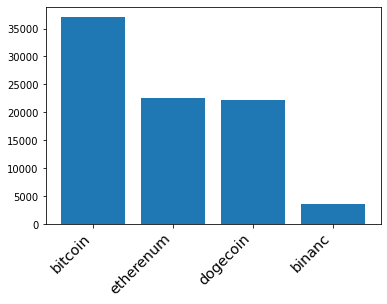

In [154]:
hashtag_ml =hashtags(tweet_train).collect()
# Cleaned Hashtag
x_hash = []
y_hash = []
for i in hashtag_ml:
  x_hash.append(i[0])
  y_hash.append(i[1])

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

plt.bar(x_hash[1:10], y_hash[1:10])
plt.show()

Then spliting training dataset into training data and validation data (80% and 20%) to test the performance of the training model.

#### Multinomial Regression Model

Setting up the Pyspark Machine Learning environments. Removing user locations since it has too many levels which leads to extremely high computational cost.

In [155]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

# Y-variables
stringIndexer = StringIndexer(inputCol="hashtags", outputCol="label")
model = stringIndexer.fit(tweet_train)
td = model.transform(tweet_train)

# X-variables
assembler = VectorAssembler(outputCol= "features")\
.setInputCols(tweet_train.drop('hashtags','id','user_location').columns)

# Setting up Multinomial Logistic Regression
lr = LogisticRegression(maxIter=10,family="multinomial")
assembler_df = assembler.transform(td)
train, validation = assembler_df.randomSplit([0.8,0.2],2022)

Fitted a Multinomial Logestic Regression model using training data

In [156]:
lrModel = lr.fit(train)

Tuning the model and checking the performance using validation data

In [157]:
predictions = lrModel.transform(validation)
accuracy = predictions.filter(predictions.label == predictions.prediction).count()/float(predictions.count())
print("The accuracy of prediction in Validation Data",accuracy)

The accuracy of prediction in Validation Data 0.6520923316575798


#### Random Forest
Using the training set to train a Random Forest with 100 total trees, and number of sqrt(col) variables to choose in each trees.

In [151]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label',numTrees=100)
rfModel = rf.fit(train)

Checking the performance using validation data

In [152]:
predictions = rfModel.transform(validation)
accuracy = predictions.filter(predictions.label == predictions.prediction).count()/float(predictions.count())
print("The accuracy of prediction in Validation Data",accuracy)

The accuracy of prediction in Validation Data 0.8439071018905332


#### Neural Network with Keras API
Converting to Pandas Dataframe for better compatibility with Keras Packages. And creating dummy variables for response variables "hashtags" since the neural network requires int variables for calculation.

In [185]:
train_df = tweet_train.drop('id').toPandas()
response = train_df.pop('hashtags')
train_df = train_df.drop(columns= 'user_location')
response = pd.get_dummies(response)

Setting up the Keras environments and a neural network model with two hidden layers, have 128 and 256 node. Setting up the Relu activation functions for non-linearity, and softmax output function for multi-class classification.

In [173]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(51,))
x = layers.Dense(128, activation="relu", name="dense_1")(inputs)
x = layers.Dense(256, activation="relu", name="dense_2")(x)
outputs = layers.Dense(5, activation="softmax", name="classification")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 51)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               6656      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 classification (Dense)      (None, 5)                 1285      
                                                                 
Total params: 40,965
Trainable params: 40,965
Non-trainable params: 0
_________________________________________________________________


The above shows the structures of our final model. And fitting it with training data and tunning it with validation splits

In [174]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy')
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_best_only=True)
model.fit(train_df, response, batch_size=32, epochs=20, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/20
3548/3548 [==============================] - 11s 3ms/step - loss: 96.7211 - val_loss: 98.0014
Epoch 2/20
3548/3548 [==============================] - 10s 3ms/step - loss: 6.7770 - val_loss: 1.2062
Epoch 3/20
3548/3548 [==============================] - 10s 3ms/step - loss: 1.2463 - val_loss: 0.8827
Epoch 4/20
3548/3548 [==============================] - 10s 3ms/step - loss: 0.9035 - val_loss: 0.8408
Epoch 5/20
3548/3548 [==============================] - 10s 3ms/step - loss: 0.9160 - val_loss: 1.0492
Epoch 6/20
3548/3548 [==============================] - 9s 3ms/step - loss: 0.7894 - val_loss: 0.6969
Epoch 7/20
3548/3548 [==============================] - 10s 3ms/step - loss: 0.7705 - val_loss: 0.6862
Epoch 8/20
3548/3548 [==============================] - 9s 3ms/step - loss: 0.7012 - val_loss: 0.6416
Epoch 9/20
3548/3548 [==============================] - 9s 3ms/step - loss: 0.6985 - val_loss: 0.6417
Epoch 10/20
3548/3548 [==============================] - 10s 3ms/step - lo

The above plot demonstrates the training process of the neural network model in each iteration. To avoid overfitting, we need to use the model with the lowest validated loss (val_loss) in the above result. This model is stored in memory by checkpoint functions and is callable for future usage.

#### Prediction
We will use the testing dataset to demonstrate the outcome of three trained models and how auto-hashtaging system works in incoming tweets.

Logestic Regression

In [179]:
from pyspark.ml.feature import IndexToString
test = assembler.transform(tweet_test)
test_prediction = lrModel.transform(test)
backtoshash = IndexToString(inputCol="prediction", outputCol="hashes",labels=['Cryptocurrency','Bitcoin','Dogecoin','Etherenum','binance'])
test_prediction = backtoshash.transform(test_prediction)
test_prediction.select('probability').show(10,False) 

+-------------------------------------------------------------------------------------------------------+
|probability                                                                                            |
+-------------------------------------------------------------------------------------------------------+
|[0.30778448183565965,0.3716310500651434,0.16161771243592402,0.1589652925699206,1.4630933523579837E-6]  |
|[0.3333537142687248,0.3741098133448035,0.1715010376349207,0.12103397160321819,1.4631483327761318E-6]   |
|[0.3913919831998295,0.30272936813125695,0.1792155530970851,0.12666167790358085,1.4176682475158857E-6]  |
|[0.3329974135218717,0.3273921487753029,0.16133842187071967,0.17827058720059538,1.4286315102385452E-6]  |
|[0.36016288146661124,0.24749006328533799,0.1546517811419832,0.23769385990119002,1.414204877543298E-6]  |
|[0.4249108782329619,0.26050991271097346,0.16350003108806135,0.15107784666919646,1.331298806697067E-6]  |
|[0.4418877795502916,0.25275216168285536,0.168

The hashtags with the highest probabilities will be the classified categories for the corresponding samples (optimal Bayes)

In [180]:
test_prediction.select('hashes').show(10,False) 

+--------------+
|hashes        |
+--------------+
|Bitcoin       |
|Bitcoin       |
|Cryptocurrency|
|Cryptocurrency|
|Cryptocurrency|
|Cryptocurrency|
|Cryptocurrency|
|Cryptocurrency|
|Bitcoin       |
|Cryptocurrency|
+--------------+
only showing top 10 rows



Random Forest
Similiar for Random Forest model and Neural Network Model

In [141]:
test_prediction = rfModel.transform(test)
backtoshash = IndexToString(inputCol="prediction", outputCol="hashes",labels=['Cryptocurrency','Bitcoin','Dogecoin','Etherenum','binance'])
test_prediction = backtoshash.transform(test_prediction)
test_prediction.select('id','probability').show(10,False) 

test_prediction.select('id','hashes').show(10,False) 

+----+-----------------------------------------------------------------------------------------------------+
|id  |probability                                                                                          |
+----+-----------------------------------------------------------------------------------------------------+
|29  |[0.09435890802488249,0.7582716429656888,0.05493783800012497,0.06160414515272831,0.030827465856575323]|
|474 |[0.11255478206922115,0.6999061134688493,0.07540501335683984,0.03469994448816886,0.07743414661692073] |
|964 |[0.2184709625496111,0.4078613906398543,0.18861018291137938,0.08705603836867488,0.0980014255304804]   |
|1677|[0.2354330216328696,0.41165138907822363,0.1725981226759297,0.08955408797770611,0.09076337863527091]  |
|1950|[0.05728613140768342,0.2067026231040679,0.034736357162703346,0.6834857395454945,0.0177891487800508]  |
|2040|[0.6647779482332601,0.20745717645452166,0.0691193825034771,0.03269237796621494,0.02595311484252625]  |
|2214|[0.6748252128

Neural Network

In [189]:
test_df = tweet_test.toPandas()
response = test_df.pop('hashtags')
test_df = test_df.drop(columns= 'user_location')
model.load_weights(checkpoint_filepath)
prediction = model.predict(test_df)
prediction[:10]

array([[4.0090967e-02, 9.2283279e-01, 6.3840480e-04, 3.5797615e-02,
        6.4031023e-04],
       [1.0000000e+00, 5.1956398e-37, 5.2178189e-17, 4.3587187e-10,
        0.0000000e+00],
       [8.1812264e-03, 9.0291202e-01, 8.0047140e-04, 7.8316398e-02,
        9.7897695e-03],
       [9.0804126e-05, 9.9990916e-01, 6.1961986e-10, 4.1065171e-08,
        1.4062863e-08],
       [2.5614072e-03, 9.2881650e-01, 2.2362829e-04, 6.2866800e-02,
        5.5316212e-03],
       [1.9398219e-18, 0.0000000e+00, 1.4154143e-10, 1.0000000e+00,
        0.0000000e+00],
       [5.9892616e-04, 9.9940050e-01, 4.2962217e-08, 5.8686703e-07,
        2.3384263e-09],
       [1.2263601e-10, 9.9999988e-01, 1.4239385e-10, 1.7541866e-07,
        2.5965613e-10],
       [2.2217000e-12, 1.0000000e+00, 1.7890312e-27, 4.2865566e-20,
        2.1427297e-31],
       [8.3586285e-03, 9.8236567e-01, 5.7860273e-03, 1.3139895e-03,
        2.1756906e-03]], dtype=float32)

In [187]:
import numpy as np
label = ['Bitcoin','Cryptocurrency','Dogecoin','Etherenum','binance']
hashtags = []
for prob in prediction:
  index_max = np.argmax(prob)
  hashtags.append(label[index_max])
hashtags[:10]

['Cryptocurrency',
 'Bitcoin',
 'Cryptocurrency',
 'Cryptocurrency',
 'Cryptocurrency',
 'Etherenum',
 'Cryptocurrency',
 'Cryptocurrency',
 'Cryptocurrency',
 'Cryptocurrency']

#### Conclusion and Possible Improvement
This project demonstrates data analysis of tweets and related information under Pyspark environments. And performing a simple text classification using three popular supervised learning models: logistic regression, Random Forest, and ANN. The Random forest model achieves 84% accuracy in the hashtag classification of the validation dataset. Therefore, the prediction can be an important metrics for an automatic tagging system for new tweets.

There are alterative choices of machine learning models for text classification in this project. For exmaple, the vectorized version of the neural network, support vector machine, KNN, and others. Some of models might have a better performance than the above models. These can be a possible improvement of this project in future developments.

Also, [Twitter API](https://developer.twitter.com/en/docs/twitter-api) provides more possibilities for data mining, such as but not limited to streaming, recent search,  and particular user search. Therefore, the Kaggle dataset in this project can be replace with other sources to improve the performance.